<a href="https://colab.research.google.com/github/saquibali7/GANs/blob/main/task01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import load
from numpy.random import randint
from PIL import Image

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import save_image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/Morula/'
file = os.listdir(path)
print(len(file))

1478


(500, 500, 3)


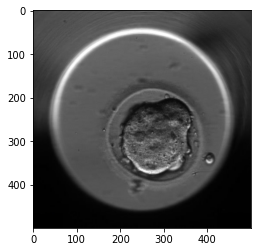

In [6]:
ix = randint(0, len(file))
rand_img = Image.open(os.path.join(path,file[ix]))
rand_img = np.array(rand_img)
print(rand_img.shape)
plt.imshow(rand_img)

### Discriminator Model

In [7]:
class Discriminator(nn.Module):
  def __init__(self, in_channels, features):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, features, 4, 2, 1),
        nn.LeakyReLU(0.2),
        self.CNNBlocks(features, features*2, 4, 2, 1),
        self.CNNBlocks(features*2, features*4, 4, 2, 1),
        self.CNNBlocks(features*4, features*8, 4, 2, 1),
        nn.Conv2d(features*8, 1, 4, 2, 0),
        nn.Sigmoid(),
    )

  def CNNBlocks(self, in_channels, out_channels, kernel_size, stride, padding):
      self.block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels,
                    kernel_size = kernel_size,
                    stride = stride,
                    padding = padding, bias=False),
      )
      return self.block

  def forward(self, x):
    return self.conv(x)    


In [8]:
def test_disc():
  x = torch.rand((1, 3, 64, 64))
  disc = Discriminator(in_channels = 3, features = 64)
  out = disc(x)
  print(out.shape)

In [9]:
test_disc()

torch.Size([1, 1, 1, 1])


## Generator Model

In [10]:
class Generator(nn.Module):
  def __init__(self, noise_channels, img_channels, features):
    super().__init__()
    self.conv = nn.Sequential(
        self.CNNBlocks(noise_channels, features*16, 4, 2, 0),
        self.CNNBlocks(features*16, features*8, 4, 2, 1),
        self.CNNBlocks(features*8, features*4, 4, 2, 1),
        self.CNNBlocks(features*4, features*2, 4, 2, 1),
        nn.ConvTranspose2d(features*2, img_channels, 4, 2 , 1),
        nn.Tanh(),
    )

  def CNNBlocks(self, in_channels, out_channels, kernel_size, stride, padding):
    self.block= nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels,
                           kernel_size=kernel_size,
                           stride = stride,
                           padding = padding,
                           bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )  
    return self.block

  def forward(self, x):
    return self.conv(x)  

In [11]:
def test_gen():
  x = torch.randn((1, 100, 1 , 1))
  gen = Generator(100, 3, 8)
  out = gen(x)
  print(out.shape)

In [12]:
test_gen()

torch.Size([1, 3, 64, 64])


In [40]:
def initialise_weight(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Conv2dTranspose, nn.BatchNorm2d)):
      nn.inti.normal_(m.weight.data, 0.0, 0.02)


## Data Preprocessing

In [13]:
device = torch.device("cude" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
IMAGE_SIZE = 64
IMG_CHANNELS = 3
NOISE_CHANNELS = 100
LEARNING_RATE = 2e-4
EPOCHS = 50

In [14]:
transforms = transforms.Compose(
    [   
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(IMG_CHANNELS)],
            [0.5 for _ in range(IMG_CHANNELS)]),
    ]
)

In [15]:
class ImageDataset(Dataset):
  def __init__(self, root_dir, transform):
    self.root_dir = root_dir
    self.files = os.listdir(root_dir)
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getItem__(self, index):
    img_file = self.files[index]
    img_path = os.path.join(self.root_dir, img_file)
    img = np.array(Image.open(img_path))
    image = self.transform(img)
    return image

